In [1]:
from multiprocessing import pool
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as kernels
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import time
import matplotlib.pyplot as plt
import os
import random
from calendar import monthrange

In [236]:
def load_data(pollutant, data_path="data/", time_step=None, time_range=None, season=None, day_of_week=None, time_of_day=None):
    """
    :param pollutant: {"CO", "NO2", "O3", "SO2", "PM10", "PM25"}
    :param data_path: path to data directory
    :param time_step: if provided, {"H", "D", "M", "Y"}
    :param time_range: if provided, get data within the given time_range, inclusive
            If second element isn't provided, defaults to present day
    :param season: true, false - creates columns for each seasons denoted by binary columns to the season datapoint belongs to
            Winter: December, January, Ferbruary
            Spring: March, April and May
            Summer: June, July and August
            Autumn: September, October and November
    :param day_of_week: true, false
            0 : weekday
            1 : weekend
    :param time_of_day: true, false
            0 : daytime
            1 : nighttime
    """
    df = pd.read_csv(f"{data_path}{pollutant}.csv", parse_dates=["date"])

    # TODO: FILTER OUT NEGATIVE VALUES FROM DF
    df = df.loc[df[pollutant.lower()] > 0]
    # get data within a given time range
    if time_range:
        start, end = time_range
        if not end:
            end = datetime.today
        df = df.loc[(df["date"] >= start) & (df["date"] <= end)]

    df = df.set_index("date")
    # daily, monthly, yearly
    if time_step in {"D", "M", "Y"}:
        index_format = {"D": "%Y-%m-%d", "M": "%Y-%m", "Y": "%Y"}
        df = df.groupby(by=["code"]).resample(time_step).mean().dropna()
        # df["date"] = df["date"].apply(lambda x: x.strftime(index_format[time_step]))

    df = df.reset_index()
    # seasonal buckets
    # creates binary column for each season 
    # (1 represents that the data point is part of that season, 0 represents not part of season)
    if season:
        seasons = {"winter": [12, 1, 2], 
                "spring": [i for i in range(3, 6)], 
                "summer" : [i for i in range(6, 9)], 
                "autumn" : [i for i in range(9, 12)]}

        df["Month"] = pd.DatetimeIndex(df['date']).month
        # print(df)

        # define condition: month must be within seasonal month range
        
        for s in seasons:
            # condition = (df.Month in seasons[season])
            condition = ((df.Month >= seasons[s][0]) & (df.Month <=seasons[s][-1]))
            if s == "winter":
                condition = ((df.Month >= seasons[s][0]) | (df.Month <= seasons[s][-1]))
            df[s] = np.where(condition, 1, 0)

        # drop created month column
        df = df.drop(["Month"], axis=1)
        
    # day of week buckets: weekday vs weekend
    # creates binary column for 'day_of_week' (1 represents weekday, 0 represents weekend)
    if day_of_week:
        weekdays = [i for i in range(5)]
        df["DayOfWeek"] = pd.DatetimeIndex(df['date']).dayofweek
        # condition = (df.DayOfWeek in weekdays)
        condition = ((df.DayOfWeek >= weekdays[0]) & (df.DayOfWeek <= weekdays[-1]))

        # add binary column denoting whether data point belongs to input day of week group
        df['day_of_week'] = np.where(condition, 1, 0)
        df = df.drop(["DayOfWeek"], axis=1)
        
    
    # daytime (7am - 5pm) vs nighttime (5pm - 7am) buckets, according to London's sunrise and sunset times
    # creates binary column for 'time_of_day' (1 represents daytime, 0 represents nighttime)
    if time_of_day:
        daytime_hours = [i for i in range(7, 18)]
        df["Hour"] = pd.DatetimeIndex(df['date']).hour
        # condition = (df.Hour in daytime_hours)

        condition = ((df.Hour >= daytime_hours[0]) & (df.Hour <= daytime_hours[-1]))
        if time_of_day == "night":
            condition = ((df.Hour >= daytime_hours[0]) | (df.Hour <= daytime_hours[-1]))

        df["time_of_day"] = np.where(condition, 1, 0)
        df = df.drop(["Hour"], axis=1)

    # generate time_step (t) column
    df = df.sort_values("date")
    dates = df["date"].values

    t = -1
    current_date = None
    time_steps = []
    for date in dates:
        if date != current_date:
            t += 1
            current_date = date
        time_steps.append(t)
    df["t"] = time_steps
    
    n = df.shape[0]
    lat_noise, lon_noise = np.random.normal(0,.001,n), np.random.normal(0,.001,n)
    df["latitude"] = df["latitude"] + lat_noise
    df["longitude"] = df["longitude"] + lon_noise
    
    return df

In [237]:
def split_data(df, test_percent=0.2):
    """
    returns: train_df, test_df, train_indices, test_indices
    """
    N, M = df.shape
    indices = np.arange(N)
    train_indices, test_indices = train_test_split(indices, test_size=test_percent)
    train_df, test_df = df.iloc[train_indices, :].copy(), df.iloc[test_indices, :].copy()
    return train_df, test_df

In [238]:
def scale_data(train_df, test_df, features):
    scalers = {}
    for feature in features:
        scaler = StandardScaler()
        train_df[f"scaled_{feature}"] = scaler.fit_transform(train_df[[feature]].values)
        test_df[f"scaled_{feature}"] = scaler.transform(test_df[[feature]].values)
        scalers[feature] = scaler
    return scalers

In [204]:
def train_GPR_model(kernel, train_df, x_features, y_features):
    model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=6, normalize_y=True)
    model.fit(train_df[x_features], train_df[y_features])
    return model

In [6]:
def save_model(filename, df, model, train_df, test_df, train_scalers):
    path = f"GPR-models/{filename}/"
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    df_filename = f"{path}{filename}_df.sav"
    model_filename = f"{path}{filename}_model.sav"
    train_df_filename = f"{path}{filename}_train_df.sav"
    test_df_filename = f"{path}{filename}_test_df.sav"
    scalers_filename = f"{path}{filename}_scalers.sav"
    pickle.dump(df, open(df_filename, "wb"))
    pickle.dump(model, open(model_filename, "wb"))
    pickle.dump(train_df, open(train_df_filename, "wb"))
    pickle.dump(test_df, open(test_df_filename, "wb"))
    pickle.dump(train_scalers, open(scalers_filename, "wb"))

In [7]:
def load_model(filename):
    path = f"GPR-models/{filename}/{filename}"
    model = pickle.load(open(f"{path}_model.sav", 'rb'))
    df = pickle.load(open(f"{path}_df.sav", 'rb'))
    train_df = pickle.load(open(f"{path}_train_df.sav", 'rb'))
    test_df = pickle.load(open(f"{path}_test_df.sav", 'rb'))
    scalers = pickle.load(open(f"{path}_scalers.sav", 'rb'))
    
    return model, df, train_df, test_df, scalers

In [111]:
def plot_site(model, df, x_features, scalers, code, lat, lon, title="Predictions after training", save=False, save_path="GPR_figures/"):
    min_t, max_t = df["t"].min(), df["t"].max()
    time_steps = np.linspace(min_t, max_t, max_t-min_t+1)
    start_date, end_date = df["date"].min(), df["date"].max()
    delta = end_date - start_date
    dates = [start_date + timedelta(days=i) for i in range(delta.days+1)]
    
    plot_df = pd.DataFrame({"t": time_steps})
    v = scalers["latitude"].transform(np.array([[lat]]))
    plot_df["scaled_latitude"] = scalers["latitude"].transform(np.array([[lat]]))[0][0]
    plot_df["scaled_longitude"] = scalers["longitude"].transform(np.array([[lon]]))[0][0]
    
    plt.figure()
    plt.subplots(facecolor="white")
    
    prediction_mean, prediction_std = model.predict(plot_df[x_features], return_std=True)
    prediction_mean, prediction_std = prediction_mean.flatten(), prediction_std.flatten()
    (line,) = plt.plot(dates, prediction_mean, lw=1.5, label="Mean of predictive posterior")
    plt.fill_between(
        dates,
        prediction_mean-1.96*prediction_std,
        prediction_mean+1.96*prediction_std,
        color=line.get_color(),
        alpha=0.6,
        label=r"95% confidence interval"
    )
    
    print(np.mean(prediction_std, axis=0))
    
    plt.title(f"Model predictions for site {code}\n")
    plt.xlabel(f"Date")
    plt.ylabel(f"Concentration of NO2 (ug/m3)")
    
    plt.gcf().autofmt_xdate()

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.legend(loc=(1.04,0))

    if save:
        plt.savefig(fname=save_path + "prediction_" + code + ".png")
    plt.show()
#    plt.close()

28.35901021810041


<Figure size 432x288 with 0 Axes>

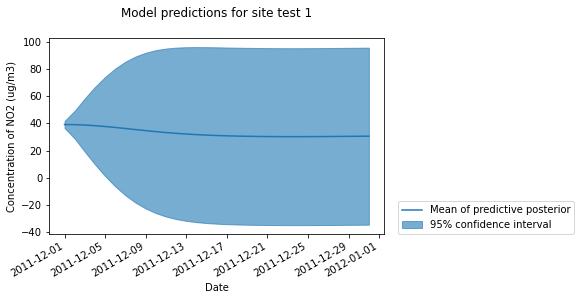

In [249]:
plot_site(model, df, x_features, scalers, "test 1", 51.565261, 0.179271)

33.96109692772369


<Figure size 432x288 with 0 Axes>

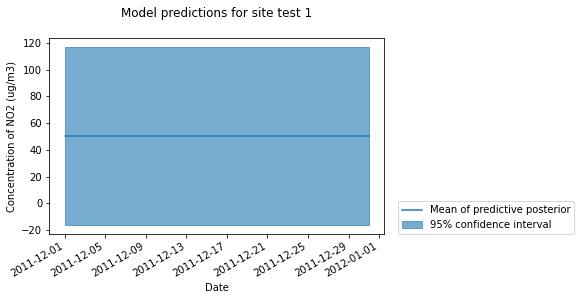

In [250]:
plot_site(model, df, x_features, scalers, "test 1", 51.56922, -0.081821)

In [171]:
def plot_model_by_site(model, df, train_df, test_df, x_fixed_features, x_features, y_features, scalers, codes, save=True, title="Predictions after training", save_path="GPR_figures/"):
    min_t, max_t = df["t"].min(), df["t"].max()
    time_steps = np.linspace(min_t, max_t, max_t-min_t+1)
    start_date, end_date = df["date"].min(), df["date"].max()
    delta = end_date - start_date
    dates = [start_date + timedelta(days=i) for i in range(delta.days+1)]
    
    for code in codes:
        plt.figure()
        plt.subplots(facecolor="white")
        
        site_train_df, site_test_df = train_df.loc[train_df["code"] == code], test_df.loc[test_df["code"] == code]
        
        # PREDICT POLLUTION AT SITE ACROSS ALL DATES IN TIME RANGE
        site_prediction_df = pd.DataFrame({"t": time_steps})
        for fixed_feature in x_fixed_features:
            site_prediction_df[fixed_feature] = site_train_df.iloc[0][fixed_feature]
        site_prediction_df = site_prediction_df[x_features]
        
        # PLOT PREDICTION
        prediction_mean, prediction_std = model.predict(site_prediction_df, return_std=True)
        prediction_mean, prediction_std = prediction_mean.flatten(), prediction_std.flatten()
        (line,) = plt.plot(dates, prediction_mean, lw=1.5, label="Mean of predictive posterior")
        plt.fill_between(
            dates,
            prediction_mean-1.96*prediction_std,
            prediction_mean+1.96*prediction_std,
            color=line.get_color(),
            alpha=0.6,
            label=r"95% confidence interval"
        )
        
        # PLOT OBSERVED (TRAIN) DATA
        plt.plot(site_train_df["date"], site_train_df[y_features], "x", label="Training observations", alpha=0.9, color="grey", linestyle="None")
        
        # PREDICT TEST DATA
        test_mean, test_std = model.predict(site_test_df[x_features], return_std=True)
        test_mean, test_std = test_mean.flatten(), test_std.flatten()

        # PLOT TEST ACTUAL VALUE
        plt.plot(site_test_df["date"], site_test_df[y_features], ".", label="Testing actual value", alpha=0.75, color="red", linestyle="None")
        
        # PLOT DIFFERENCE BETWEEN TEST PREDICTION AND ACTUAL VALUE
        test_dates = site_test_df["date"].values
        plt.plot((test_dates, test_dates), (test_mean, site_test_df[y_features].values.flatten()), c='red')# , label="Prediction error")
        
        # PLOT TEST PREDICTION
        plt.plot(site_test_df["date"], test_mean, "o", label="Testing predictions", alpha=0.75, color="blue", linestyle="None")
        # percent_error = np.absolute(1 - np.divide(test_mean, site_test_df[y_features].values.flatten()))*100
        # plt.scatter(site_test_df["date"], test_mean, c=percent_error, vmin=0, vmax=round(np.max(percent_error)), cmap="bwr", label="Testing points")
        # plt.colorbar()
        
        # SCORE TEST DATA
        score = model.score(site_test_df[x_features], site_test_df[y_features])
        
        plt.title(f"Model predictions for site {code}\n Test score (n={site_test_df.shape[0]}): {score}")
        plt.xlabel(f"Date")
        plt.ylabel(f"Concentration of NO2 (ug/m3)")

        # create folder for model run
        isExist = os.path.exists(save_path)
        if not isExist:
            os.makedirs(save_path)

        plt.gcf().autofmt_xdate()
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        plt.legend(loc=(1.04,0))
        
        if save:
            plt.savefig(fname=save_path + "prediction_" + code + ".png")
        plt.close()

In [251]:
"""
SPECIFY DATA PARAMETERS
"""
pollutant = "NO2"
time_step = "D"
time_range = (datetime(2011, 12, 1), datetime(2011, 12, 31))
season = False
day_of_week = False
time_of_day = False
field_strings = filter(None, [pollutant, time_step, time_range[0].strftime("%m%d%Y"), time_range[1].strftime("%m%d%Y"), str(season), str(day_of_week), str(time_of_day)])

random_id = random.randint(0, 10000)
figure_title = "_".join(field_strings)
filename = figure_title = f"{random_id}_{figure_title}"

In [252]:
filename

'7297_NO2_D_12012011_12312011_False_False_False'

In [253]:
alex_data_path = "../../data/"
ana_data_path = "../data-collection/LAQN_API_data/"
df = load_data(pollutant, data_path=alex_data_path, time_step=time_step, time_range=time_range, season=season, day_of_week=day_of_week, time_of_day=time_of_day)
df.shape

(2655, 7)

In [254]:
df.head()

code       date         nox        no2   latitude  longitude  t
0     BG1 2011-12-01   51.972066  39.193112  51.562909   0.177234  0
1001  GR4 2011-12-01   45.383261  30.850652  51.452895   0.071038  0
2517  WA2 2011-12-01  102.828157  58.770441  51.456723  -0.188725  0
970   GN4 2011-12-01  207.717480  70.544380  51.435963   0.064195  0
1806  LB6 2011-12-01   92.385822  52.553409  51.426396  -0.132374  0

In [255]:
train_df, test_df = split_data(df)

In [256]:
scaled_features = ["latitude", "longitude"]
scalers = scale_data(train_df, test_df, ["latitude", "longitude"])

In [243]:
"""
SPECIFY KERNEL PARAMETERS
"""
PERIODICITY = 7
kernel = kernels.ExpSineSquared(periodicity=PERIODICITY)*kernels.RBF([0, 0, 1.0]) + kernels.RBF([1.0, 1.0, 0])

In [244]:
x_features = ["scaled_latitude", "scaled_longitude", "t"]
y_features = ["no2"]

In [245]:
model = train_GPR_model(kernel, train_df, x_features, y_features)

/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:285: RuntimeWarning:

divide by zero encountered in log

/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



In [149]:
save_model(filename, df, model, train_df, test_df, train_scalers)

In [150]:
model.feature_names_in_

array(['scaled_latitude', 'scaled_longitude', 't'], dtype=object)

In [246]:
model.score(test_df[x_features], test_df[y_features])

0.36020729803119556

In [233]:
test_df.head()

code       date         nox         no2   latitude  longitude   t  \
225   BT6 2011-12-09  126.625902   53.073946  51.474665  -0.186058   8   
1745  KC4 2011-12-02  354.492785  119.567129  51.503643  -0.111450   1   
2124  RB5 2011-12-09  141.995686   66.221258  51.620609  -0.078166   8   
2115  RB4 2011-12-31   49.239041   36.722530  51.614233   0.046652  30   
2622  WA9 2011-12-30   64.027352   39.689593  51.446109  -0.240685  29   

      scaled_latitude  scaled_longitude  
225         -0.371253         -0.355940  
1745        -0.000695          0.096613  
2124         1.495060          0.298503  
2115         1.413518          1.055613  
2622        -0.736435         -0.687290

In [173]:
x_fixed_features = ["scaled_latitude", "scaled_longitude"]
site_codes = df["code"].unique()
save_path = f"GPR_figures/{filename}/"
plot_model_by_site(model, df, train_df, test_df, x_fixed_features, x_features, y_features, scalers, site_codes, save=True, save_path=save_path)

/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [9]:
# LOAD MODEL
filename = "3772_NO2_D_09012020_12312020"
model, df, train_df, test_df, scalers = load_model(filename)

/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [10]:
test_df.head()

code       date        nox        no2   latitude  longitude    t  \
6085  LB5 2020-10-01  82.623542  40.469735  51.485487  -0.124545   30   
4823  HR1 2020-12-20  20.326494  18.649158  51.617327  -0.298775  110   
1653  CT3 2020-09-09  22.204179  17.410888  51.513847  -0.077766    8   
242   BG2 2020-12-30  89.483204  36.990038  51.529389   0.132857  120   
1169  BY7 2020-09-30  32.859231  20.637903  51.405546   0.018882   29   

      scaled_latitude  scaled_longitude  
6085        -0.231456         -0.206121  
4823         1.968695         -1.484283  
1653         0.241823          0.137058  
242          0.501185          1.682202  
1169        -1.565508          0.846073

In [11]:
# NOT WHAT WE WANT, THIS IS A DENSITY PLOT

import plotly.express as px
from generate_sample_U import *

def plot_model_uncertainty(model, df, x_features):
    sites_info_df = pd.read_csv("../../data/monitoring_sites.csv")
    
    df_sites = df["code"].unique()
    
    S_df = sites_info_df.loc[sites_info_df['SiteCode'].isin(df_sites)][['SiteCode', 'Latitude', 'Longitude']]
    S_df = S_df.rename(columns={"SiteCode": "code", "Latitude": "latitude", "Longitude": "longitude"})
    S_df["t"] = 0
    
    _, U_df = generate_placement_sets()
    U_df = U_df.rename(columns={"SiteCode": "code", "Latitude": "latitude", "Longitude": "longitude"})
    U_df["t"] = 0
    
    for feature in scalers:
        S_df[f"scaled_{feature}"] = scalers[feature].transform(S_df[[feature]].values)
        U_df[f"scaled_{feature}"] = scalers[feature].transform(U_df[[feature]].values)
    
    uncertainty_df = S_df.append(U_df)
    
    prediction_mean, prediction_std = model.predict(uncertainty_df[x_features], return_std=True)
    prediction_var = np.square(prediction_std)
    
    uncertainty_df["variance"] = prediction_var
    
    fig = px.density_mapbox(uncertainty_df,
                            lat="latitude",
                            lon="longitude",
                            z="variance",
                            radius=10,
                            center=dict(lat=51.509865, lon=-0.118092),
                            zoom=9,
                            hover_name="code",
                            mapbox_style="carto-positron")
    
    fig.show()

In [12]:
plot_model_uncertainty(model, df, ["scaled_latitude", "scaled_longitude", "t"])

In [13]:
def gen_A(model, df, scalers, x_features):
    sites_info_df = pd.read_csv("../../data/monitoring_sites.csv")
    
    df_sites = df["code"].unique()
    
    S_df = sites_info_df.loc[sites_info_df['SiteCode'].isin(df_sites)][['SiteCode', 'Latitude', 'Longitude']]
    S_df = S_df.rename(columns={"SiteCode": "code", "Latitude": "latitude", "Longitude": "longitude"})
    S_df["group"] = "S"
    S_df["t"] = 0
    print(S_df.shape)
    
    _, U_df = generate_placement_sets()
    U_df = U_df.rename(columns={"SiteCode": "code", "Latitude": "latitude", "Longitude": "longitude"})
    U_df["group"] = "U"
    U_df["t"] = 0
    print(U_df.shape)
    
    for feature in scalers:
        S_df[f"scaled_{feature}"] = scalers[feature].transform(S_df[[feature]].values)
        U_df[f"scaled_{feature}"] = scalers[feature].transform(U_df[[feature]].values)
    
    A_df = S_df.append(U_df)
    
    return A_df

In [15]:
x_features = ["scaled_latitude", "scaled_longitude", "t"]
uncertainty_df = gen_A(model, df, scalers, x_features)

(95, 5)
(100, 5)


In [16]:
uncertainty_df.head()

code   latitude  longitude group  t  scaled_latitude  scaled_longitude
2   BG1  51.563752   0.177891     S  0         1.074635          2.012575
3   BG2  51.529389   0.132857     S  0         0.501185          1.682202
8   BX2  51.490610   0.158914     S  0        -0.145956          1.873362
10  BQ7  51.494649   0.137279     S  0        -0.078562          1.714643
15  BX1  51.465983   0.184877     S  0        -0.556931          2.063825

In [183]:
import math

def contour_plot_v2(model, df, scalers, x_features, grid_size=25, t_max=0, t_min=0):
    def batch_predict(t_df, batch_size=25000):
        data_size = t_df['t'].shape[0]
        num_batches = math.ceil(data_size/batch_size)

        pred_mean, pred_std = np.array([]), np.array([]) # initialize empty
        for b in range(num_batches):
            batch_df = pd.DataFrame()
            batch_df["scaled_latitude"] = t_df["scaled_latitude"].values[b*batch_size:(b+1)*batch_size]
            batch_df["scaled_longitude"] = t_df["scaled_longitude"].values[b*batch_size:(b+1)*batch_size]
            batch_df["t"] = t_df["t"].values[b*batch_size:(b+1)*batch_size]
            batch_mean, batch_std = model.predict(batch_df[x_features], return_std=True)
            pred_mean = np.append(pred_mean, batch_mean)
            pred_std = np.append(pred_std, batch_std)
            
        return pred_mean, pred_std
    
    sites_info_df = pd.read_csv("../../data/monitoring_sites.csv")
    
    df_sites = df["code"].unique()
    
    S_df = sites_info_df.loc[sites_info_df['SiteCode'].isin(df_sites)][['SiteCode', 'Latitude', 'Longitude']]
    S_df = S_df.rename(columns={"SiteCode": "code", "Latitude": "latitude", "Longitude": "longitude"})
    S_df["group"] = "S"
    #S_df["t"] = t
    
    _, U_df = generate_placement_sets()
    U_df = U_df.rename(columns={"SiteCode": "code", "Latitude": "latitude", "Longitude": "longitude"})
    U_df["group"] = "U"
    #U_df["t"] = t
    
    for feature in scalers:
        S_df[f"scaled_{feature}"] = scalers[feature].transform(S_df[[feature]].values)
        U_df[f"scaled_{feature}"] = scalers[feature].transform(U_df[[feature]].values)
    
    uncertainty_df = S_df#.append(U_df)
    
    Z_s = []
    for t in range(t_min, t_max+1):
        x = np.linspace(uncertainty_df[['latitude']].min(), uncertainty_df[['latitude']].max(), num=grid_size)
        #x = np.sort(np.append(x, uncertainty_df[['latitude']].to_numpy(), axis=0), axis=0)
        y = np.linspace(uncertainty_df[['longitude']].min(), uncertainty_df[['longitude']].max(), num=grid_size)
        #y = np.sort(np.append(y, uncertainty_df[['longitude']].to_numpy(), axis=0), axis=0)
        # x = np.sort(uncertainty_df[['latitude']].values, axis=0)
        # y = np.sort(uncertainty_df[['longitude']].values, axis=0)

        scaled_x = scalers['latitude'].transform(x).flatten()
        scaled_y = scalers['longitude'].transform(y).flatten()
        
        expanded_x, expanded_y = [], []
        n, m = scaled_x.shape[0], scaled_y.shape[0]
        for i in range(n):
            for j in range(m):
                expanded_x.append(scaled_x[i])
                expanded_y.append(scaled_y[j])

        t_df = pd.DataFrame(data={"scaled_latitude": expanded_x, "scaled_longitude": expanded_y})
        t_df['t'] = t
        
        pred_mean, pred_std = batch_predict(t_df)
        Z = np.square(pred_std).reshape(n, m)
        Z_s.append(Z)
    Z = np.mean(Z_s, axis=0)
    
    X, Y = np.meshgrid(x, y)
    
    return X, Y, Z

In [157]:
def contour_plot(model, df, scalers, x_features, grid_size=25, t_max=0, t_min=0):
    def get_var(x, y, t):
        pt_df = pd.DataFrame(data={"scaled_latitude":[x], "scaled_longitude":[y], "t":[t]})
        pred_mean, pred_std = model.predict(pt_df, return_std=True)
        pred_var = pred_std[0]**2
        return pred_var

    sites_info_df = pd.read_csv("../../data/monitoring_sites.csv")
    
    df_sites = df["code"].unique()
    
    S_df = sites_info_df.loc[sites_info_df['SiteCode'].isin(df_sites)][['SiteCode', 'Latitude', 'Longitude']]
    S_df = S_df.rename(columns={"SiteCode": "code", "Latitude": "latitude", "Longitude": "longitude"})
    S_df["group"] = "S"
    #S_df["t"] = t
    
    _, U_df = generate_placement_sets()
    U_df = U_df.rename(columns={"SiteCode": "code", "Latitude": "latitude", "Longitude": "longitude"})
    U_df["group"] = "U"
    #U_df["t"] = t
    
    for feature in scalers:
        S_df[f"scaled_{feature}"] = scalers[feature].transform(S_df[[feature]].values)
        U_df[f"scaled_{feature}"] = scalers[feature].transform(U_df[[feature]].values)
    
    uncertainty_df = S_df#.append(U_df)
    
    Z = []
    for t in range(t_min, t_max+1):
        x = np.linspace(uncertainty_df[['latitude']].min(), uncertainty_df[['latitude']].max(), grid_size)
        #=x = np.sort(np.append(x, uncertainty_df[['latitude']].to_numpy(), axis=0), axis=0)
        y = np.linspace(uncertainty_df[['longitude']].min(), uncertainty_df[['longitude']].max(), grid_size)
        #y = np.sort(np.append(y, uncertainty_df[['longitude']].to_numpy(), axis=0), axis=0)
        # x = np.sort(uncertainty_df[['latitude']].values, axis=0)
        # y = np.sort(uncertainty_df[['longitude']].values, axis=0)


        scaled_x = scalers['latitude'].transform(x).flatten()
        scaled_y = scalers['longitude'].transform(y).flatten()

        n = scaled_x.shape[0]
        m = scaled_y.shape[0]
        Z_t = []
        for i in range(n):
            z_row = []
            for j in range(m):
                z_row.append(get_var(scaled_x[i], scaled_y[j], t))
            Z_t.append(z_row)
        Z.append(Z_t)
    Z = np.mean(np.array(Z), axis=0)
    
    X, Y = np.meshgrid(x, y)
    
    return X, Y, Z

In [182]:
df['t'].max()

121

In [184]:
x_features = ["scaled_latitude", "scaled_longitude", "t"]
cont_X, cont_Y, cont_Z = contour_plot_v2(model, df, scalers, x_features, grid_size=25, t_max=121, t_min=0)

In [185]:
cont_X.shape

(25, 25)

In [195]:
kernel

ExpSineSquared(length_scale=1, periodicity=7) * RBF(length_scale=[0, 0, 1]) + RBF(length_scale=[1, 1, 0])

In [71]:
A_df = gen_A(model, df, scalers, x_features)
A_df.head()

(95, 5)
(100, 5)


code   latitude  longitude group  t  scaled_latitude  scaled_longitude
2   BG1  51.563752   0.177891     S  0         1.074635          2.012575
3   BG2  51.529389   0.132857     S  0         0.501185          1.682202
8   BX2  51.490610   0.158914     S  0        -0.145956          1.873362
10  BQ7  51.494649   0.137279     S  0        -0.078562          1.714643
15  BX1  51.465983   0.184877     S  0        -0.556931          2.063825

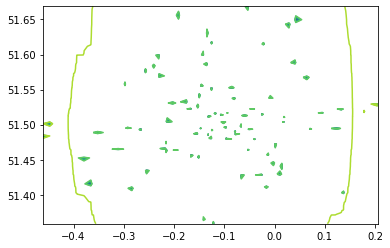

In [72]:
plt.contour(cont_Y, cont_X, cont_Z)
plt.show()

In [73]:
import geopandas as gpd
from geopandas import GeoDataFrame

In [154]:
map_filepath = "../../data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"
map_df = gpd.read_file(map_filepath)
map_df = map_df.to_crs("EPSG:4326")
map_df.head()

NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER SUB_2009  \
0  Kingston upon Thames  E09000021   3726.117       0.000         F     None   
1               Croydon  E09000008   8649.441       0.000         F     None   
2               Bromley  E09000006  15013.487       0.000         F     None   
3              Hounslow  E09000018   5658.541      60.755         F     None   
4                Ealing  E09000009   5554.428       0.000         F     None   

  SUB_2006                                           geometry  
0     None  POLYGON ((-0.33066 51.32901, -0.33057 51.32909...  
1     None  POLYGON ((-0.06399 51.31864, -0.06405 51.31861...  
2     None  POLYGON ((0.01216 51.29960, 0.01199 51.29979, ...  
3     None  POLYGON ((-0.24454 51.48870, -0.24466 51.48868...  
4     None  POLYGON ((-0.41181 51.53408, -0.41186 51.53413...

<AxesSubplot:>

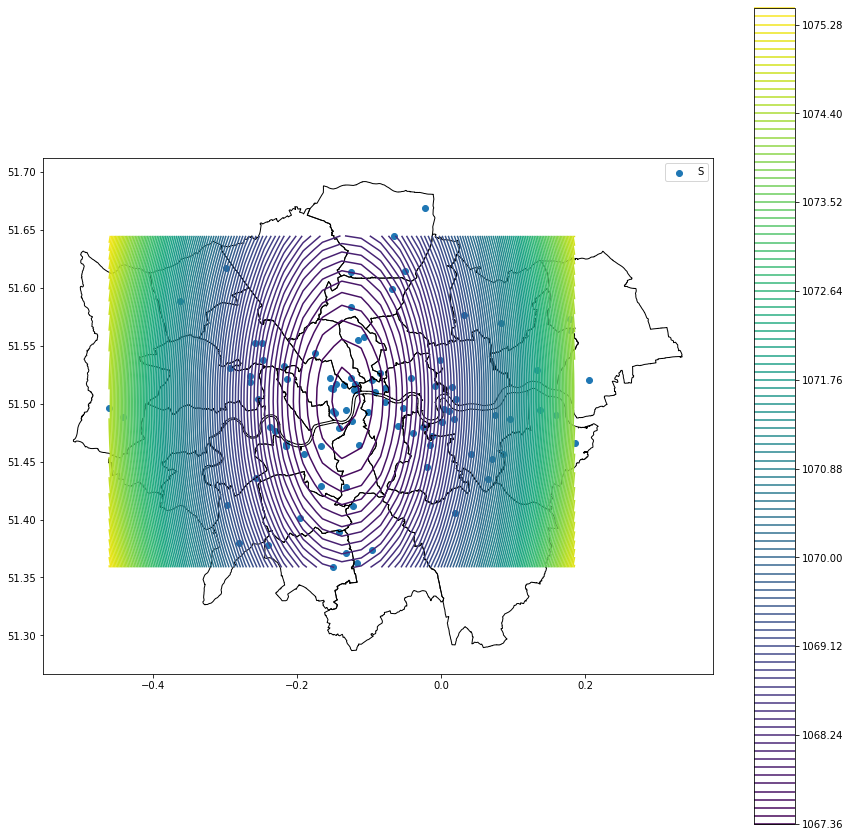

In [186]:
# 1. average across all t's
# 2. double check how we're quantifying uncertainty
# 3. check contour function behavior
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(15,15))

#normi = mpl.colors.Normalize(vmin=cont_Z.min(), vmax=cont_Z.max())

plt.contour(cont_Y, cont_X, cont_Z, levels=100)#, norm=normi, extend='both')
plt.colorbar()

for group in A_df["group"].unique():
    group_df = A_df.loc[A_df["group"] == group]
    #plt.scatter(cont_Y, cont_X, label="sim points")
    plt.scatter(group_df["longitude"], group_df["latitude"], label=group)
    break
    
ax.legend()
map_df.plot(ax=ax, color="None")

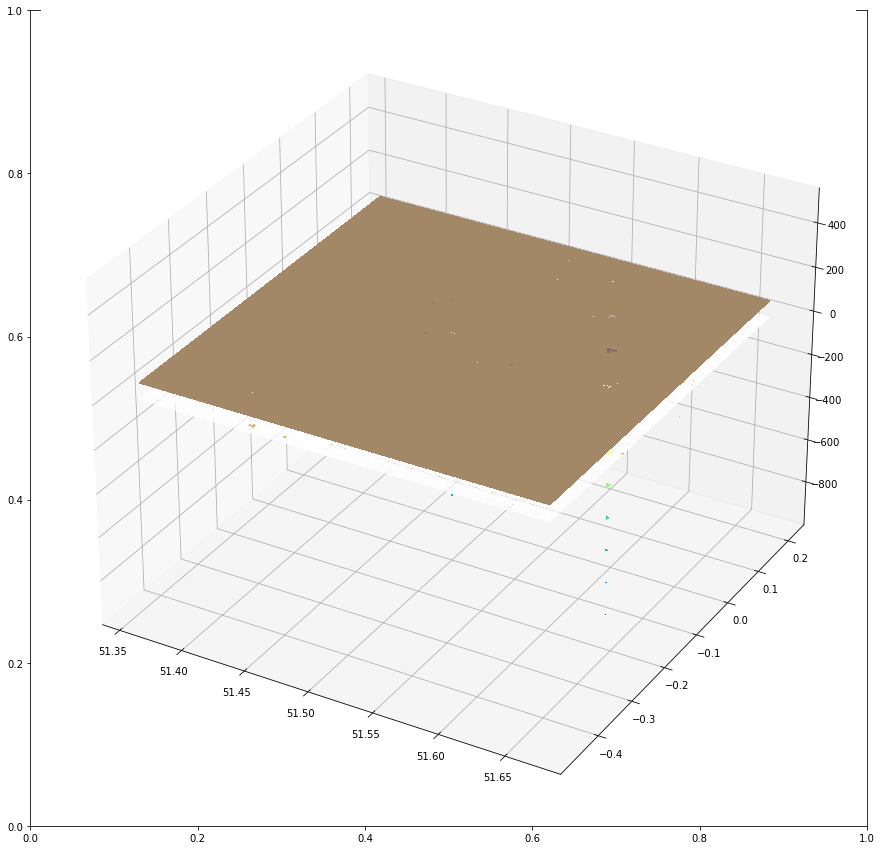

In [247]:
import matplotlib.tri as mtri

fig, ax = plt.subplots(figsize=(15,15))

triang = mtri.Triangulation(cont_X.flatten(), cont_Y.flatten())
refiner = mtri.UniformTriRefiner(triang)
tri_refi, z_test_refi = refiner.refine_field(cont_Z.flatten(), subdiv=3)

# Plot the surface.
ax = fig.add_subplot(projection='3d')
ax.triplot(triang, lw=0.5, color="white")
ax.tricontourf(tri_refi, z_test_refi, levels=10, cmap='terrain')


plt.show()

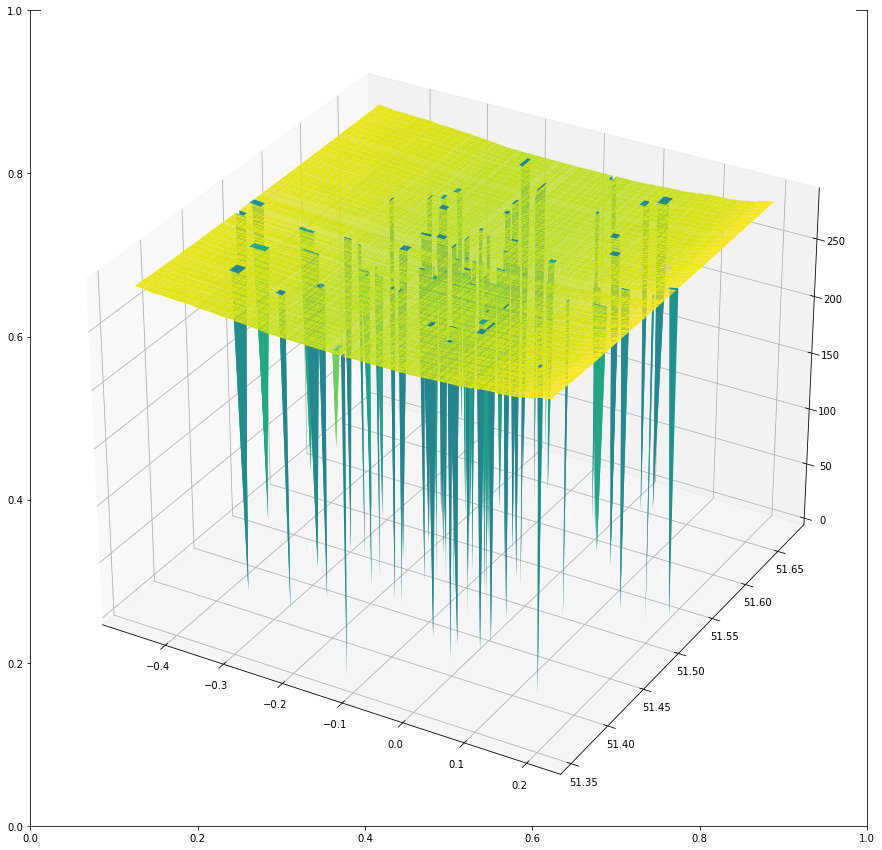

In [32]:
fig, ax = plt.subplots(figsize=(15,15))

ax = plt.axes(projection='3d')
ax.plot_surface(cont_Y, cont_X, cont_Z, rstride=1, cstride=1,
              cmap='viridis', edgecolor='none')


#ax.contourf(cont_Y, cont_X, cont_Z)

# for group in A_df["group"].unique():
#     group_df = A_df.loc[A_df["group"] == group]
#     plt.scatter(group_df["longitude"], group_df["latitude"], label=group)
#     break
#ax.legend()
#map_df.to_crs("EPSG:4326").plot(ax=ax, color="None")